In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import ensemble
import sklearn.model_selection as ms
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math as m
from matplotlib.colors import LogNorm
import collections
import pickle
import itertools

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
N_THREADS = 88
os.environ['OMP_NUM_THREADS'] = str(N_THREADS)
# sns.set(font_scale=1., style='white')
seed = 42

## Helper funtion for I/O, BDT analysis and evaluation of results

In [3]:
def fileparser(path, dlist, frac=0.5, sample=0, L=1):
    df = pd.read_csv(path)
    df.drop(columns=dlist, inplace=True)    
    n = len(df)
    weight = int(round(np.abs(df['weight'].sum()) * 3. * 1e6 * L)) ## The abs(mean()) is taken to make the weight of ybyt +ve
    df['weight'] = df['weight']/np.abs(df['weight'])
    if sample != 0:
        df_train = df.sample(n=sample, random_state=seed)
        df_test = df.drop(df_train.index)
    else :
        df_test = df.sample(frac=frac, random_state=seed)
        df_train = df.drop(df_test.index)
    return df_train, df_test, weight

def runBDT(df, class_names, filename, shap_plot, rf=False, depth=30, sample=1):
    mshap = True if depth <= 10 else False
    df = df.sample(frac=sample)
    X = df.drop(columns=['class', 'weight'])
    y = df['class'].values

    """ Split for training and testing
    """
    x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.2)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    """ Fit the decision tree
    """
    if rf: 
        classifier = ensemble.RandomForestClassifier(max_depth=depth, n_estimators=1000, criterion='gini', n_jobs=int(N_THREADS/2))
        classifier = classifier.fit(x_train, y_train)
    else: 
        classifier = xgb.XGBClassifier(max_depth=depth, learning_rate=0.01, objective='multi:softprob', num_class=nchannels,
                                         nthread=N_THREADS, subsample=0.5, colsample_bytree=1, n_estimators=5000)
        classifier = classifier.fit(x_train, y_train, early_stopping_rounds=50, eval_set=eval_set,
                                eval_metric=["merror", "mlogloss"], verbose=False)
    
    """ Predictions
    """
    y_pred = classifier.predict(x_test)
    print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(y_test, y_pred)))
    pickle.dump(classifier, open(filename, 'wb'))
    
    if mshap:
        X_shap = pd.DataFrame(x_test, columns=df.drop(columns=['class', 'weight']).columns)
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_shap)
        shap.summary_plot(shap_values, X_shap, plot_type='bar', class_names=class_names, class_inds='original', plot_size=(9,6), show=False)
        ax = plt.gca()
        ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
        vals = ax.get_xticks()
        ax.tick_params(labelsize=14)
        for tick in vals:
            ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#808080', zorder=1)
        plt.tight_layout()
        plt.savefig(shap_plot)
    return classifier, x_test, y_test

def eval_training(classifier):
    results = classifier.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)

    # plot log loss
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='train')
    plt.plot(x_axis, results['validation_1']['mlogloss'], label='test')
    plt.legend()

    plt.ylabel('log loss')
    plt.title('Classifier log loss')
    plt.grid()

    # plot classification error
    plt.subplot(1, 2, 2)
    plt.plot(x_axis, results['validation_0']['merror'], label='train')
    plt.plot(x_axis, results['validation_1']['merror'], label='test')
    plt.legend()

    plt.ylabel('Classification Error')
    plt.title('Classification Error')
    plt.grid()
    plt.show()
    
def get_mclass(i, df_array, weight_array, ps_exp_class, seed=seed):
    mclass = []
    for j in range(nchannels):
        mclass.append(collections.Counter(classifier.predict(df_array[j].iloc[:,:-2].values))[i]/len(df_array[j])*weight_array[j]/weight_array[i])

    sig = np.sqrt(ps_exp_class[i])*mclass[i]/np.sum(mclass)
    nevents = np.round(ps_exp_class[i]/np.sum(mclass)*np.array(mclass)).astype(int)
    print('sig: {:2.2f}, yb2 events: {}, ybyt events: {}, yt2 events: {}, zh events: {}, bbxaa events: {}'.format(sig, nevents[4], nevents[3], nevents[2], nevents[1], nevents[0]))
    return nevents, sig 

## 14 TeV Analysis

In [4]:
# dlist = ['dphibb', 'etaaa', 'ptb2', 'drbamin', 'met', 'etaa2', 'etab1', 'etaa1', 'nbjet', 'etab2', 'pta1', 'drba1', 'pta2', 'dphiba1', 'njjet', 'mbbh', 'maa']
dlist = ['dphibb', 'etaaa', 'ptb2', 'drbamin', 'met', 'etaa2', 'etab1', 'etaa1', 'nbjet', 'etab2']

# 14 TeV
df_yb2, df_yb2_test, weight_yb2 = fileparser("ROOT/gencut_set9/yb2.csv", dlist, sample=20000)
df_ybyt, df_ybyt_test, weight_ybyt = fileparser("ROOT/gencut_set9/ybyt.csv", dlist, sample=20000)
df_yt2, df_yt2_test, weight_yt2 = fileparser("ROOT/gencut_set9/yt2.csv", dlist, sample=20000)
df_zh, df_zh_test, weight_zh = fileparser("ROOT/gencut_set9/zh.csv", dlist, sample=40000)
df_bbxaa, df_bbxaa_test, weight_bbxaa = fileparser("ROOT/gencut_set9/bbxaa.csv", dlist, sample=100000)

print("No. of yb2 events: train = {}, test = {}".format(df_yb2.shape[0],df_yb2_test.shape[0]))
print("No. of ybyt events: train = {}, test = {}".format(df_ybyt.shape[0],df_ybyt_test.shape[0]))
print("No. of yt2 events: train = {}, test = {}".format(df_yt2.shape[0],df_yt2_test.shape[0]))
print("No. of zh events: train = {}, test = {}".format(df_zh.shape[0],df_zh_test.shape[0]))
print("No. of bbxaa events: train = {}, test = {}".format(df_bbxaa.shape[0],df_bbxaa_test.shape[0]))

No. of yb2 events: train = 20000, test = 26740
No. of ybyt events: train = 20000, test = 18341
No. of yt2 events: train = 20000, test = 81774
No. of zh events: train = 40000, test = 139021
No. of bbxaa events: train = 100000, test = 37488


## The Zh vs. yb2 analysis

In [8]:
channels = [df_yb2, df_zh]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 79.44% 


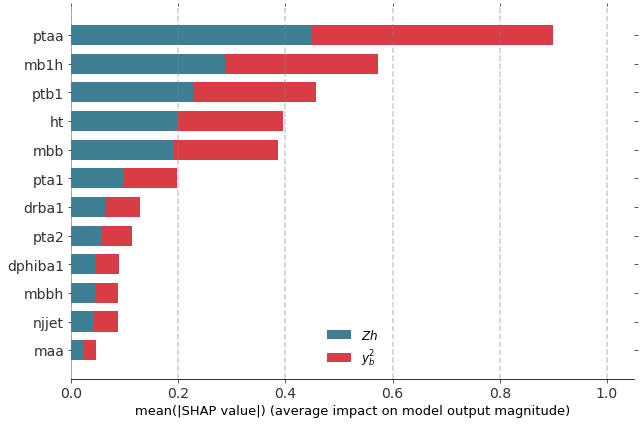

In [18]:
class_names = [r'$Zh$', r'$y_b^2$']
filename = 'models/HL-LHC-BDT/hbb-BDT-2class-bg-1b-met-ht-btag.pickle.dat'
shap_plot = '../plots/HL-LHC/shap-zh-yb2.pdf'
classifier, x_test, y_test = runBDT(df_train, class_names=class_names, filename=filename, shap_plot=shap_plot, rf=False, depth=10, sample=1)

In [9]:
classifier = pickle.load(open('models/HL-LHC-BDT/hbb-BDT-2class-bg-1b-met-ht-btag.pickle.dat', 'rb'))
comb_test = pd.concat([df_yb2_test.iloc[:,:-1].sample(n=20000, random_state=seed), df_zh_test.iloc[:,:-1].sample(n=20000, random_state=seed)])
print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(comb_test['class'].values, classifier.predict(comb_test.drop(columns=['class']).values))))

Accuracy Score: 74.00% 


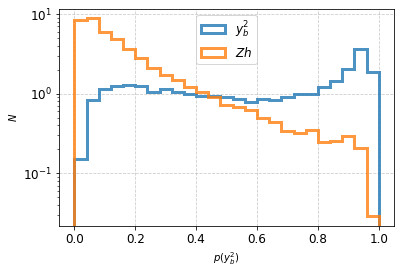

In [17]:
plt.figure(figsize=(6,4))
sns.distplot(yb2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [0.001]*len(yb2_pred[0])}, label=r'$y_b^2$')
sns.distplot(zh_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [0.001]*len(zh_pred[0])}, label=r'$Zh$')
plt.legend(loc='upper center', fontsize=12)
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel(r'$p(y_b^2)$', fontsize=12)
plt.ylabel(r'$N$', fontsize=12)
plt.yscale('log')
plt.savefig('../plots/HL-LHC/zh-yb2-BDT-dist.pdf')

## The 5 class classfication

In [9]:
channels = [df_yb2, df_ybyt, df_yt2, df_zh, df_bbxaa]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

# Special treatment for ybyt
df_tmp = pd.read_csv("ROOT/gencut_set9/ybyt.csv")
ybyt_ratio = df_tmp[df_tmp['weight']<0].shape[0]/df_tmp[df_tmp['weight']>0].shape[0]

### Run this cell only if you want to rerun the classifier

Accuracy Score: 64.10% 


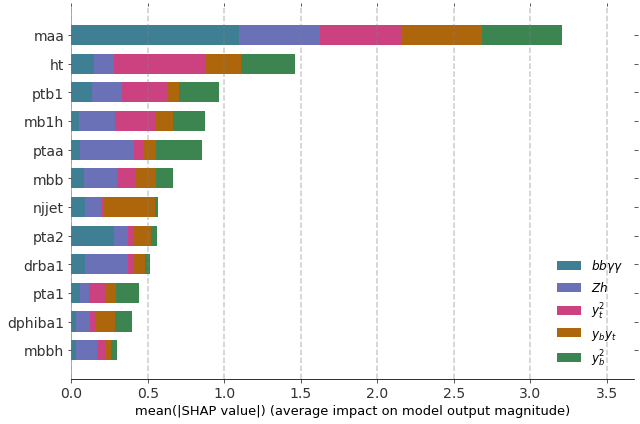

In [12]:
class_names = [r'$bb\gamma\gamma$', r'$Zh$', r'$y_t^2$', r'$y_by_t$', r'$y_b^2$']
filename = 'models/HL-LHC-BDT/hbb-BDT-multiclass-bg-1b-met-ht-btag.pickle.dat'
shap_plot = '../plots/HL-LHC/shap-5.pdf'
classifier, x_test, y_test = runBDT(df_train, class_names=class_names, filename=filename, shap_plot=shap_plot, rf=False, depth=10, sample=1)

#### Load the Classifier and run the analysis. The Accuracy is measured with eqisized samples

In [13]:
classifier = pickle.load(open('models/HL-LHC-BDT/hbb-BDT-multiclass-bg-1b-met-ht-btag.pickle.dat', 'rb'))
comb_test = pd.concat([df_yb2_test.iloc[:,:-1].sample(n=20000, random_state=seed), df_ybyt_test.iloc[:,:-1].sample(n=20000, random_state=seed),
                       df_yt2_test.iloc[:,:-1].sample(n=20000, random_state=seed), df_zh_test.iloc[:,:-1].sample(n=20000, random_state=seed),
                       df_bbxaa_test.iloc[:,:-1].sample(n=20000, random_state=seed)])
print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(comb_test['class'].values, classifier.predict(comb_test.drop(columns=['class']).values))))

Accuracy Score: 50.74% 


#### Check the accuracy of each sample and display the classification plot

Accuracy Score for yb2: 28.63% 
Accuracy Score for ybyt: 20.64% 
Accuracy Score for yt2: 25.25% 
Accuracy Score for zh: 64.18% 
Accuracy Score for bbxaa: 87.81% 


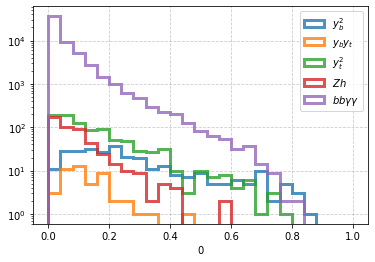

In [14]:
disc = 4
yb2_p = pd.DataFrame(classifier.predict_proba(df_yb2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yb2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yb2_test['class'].values, classifier.predict(df_yb2_test.drop(columns=['class', 'weight']).values))))
yb2_p['weight'] = df_yb2_test['weight'].values

ybyt_p = pd.DataFrame(classifier.predict_proba(df_ybyt_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for ybyt: {:4.2f}% '.format(100*metrics.accuracy_score(df_ybyt_test['class'].values, classifier.predict(df_ybyt_test.drop(columns=['class', 'weight']).values))))
ybyt_p['weight'] = df_ybyt_test['weight'].values

yt2_p = pd.DataFrame(classifier.predict_proba(df_yt2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yt2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yt2_test['class'].values, classifier.predict(df_yt2_test.drop(columns=['class', 'weight']).values))))
yt2_p['weight'] = df_yt2_test['weight'].values

zh_p = pd.DataFrame(classifier.predict_proba(df_zh_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for zh: {:4.2f}% '.format(100*metrics.accuracy_score(df_zh_test['class'].values, classifier.predict(df_zh_test.drop(columns=['class', 'weight']).values))))
zh_p['weight'] = df_zh_test['weight'].values

bbxaa_p = pd.DataFrame(classifier.predict_proba(df_bbxaa_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(df_bbxaa_test['class'].values, classifier.predict(df_bbxaa_test.drop(columns=['class', 'weight']).values))))
bbxaa_p['weight'] = df_bbxaa_test['weight'].values

yb2_pred = yb2_p.sample(n=round(weight_yb2*1.5), replace=True).reset_index(drop=True)
ybyt_pred = ybyt_p.sample(n=round(weight_ybyt*1.9), replace=True).reset_index(drop=True)
yt2_pred = yt2_p.sample(n=round(weight_yt2*2.5), replace=True).reset_index(drop=True)
zh_pred = zh_p.sample(n=round(weight_zh*1.93), replace=True).reset_index(drop=True)
bbxaa_pred = bbxaa_p.sample(n=round(weight_bbxaa*1.5), replace=True).reset_index(drop=True)

plt.figure(figsize=(6,4))
sns.distplot(yb2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_b^2$')
sns.distplot(ybyt_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_by_t$')
sns.distplot(yt2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_t^2$')
sns.distplot(zh_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$Zh$')
sns.distplot(bbxaa_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$bb\gamma\gamma$')
plt.legend()
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.yscale('log')

#### Since ybyt has both positive and negative weights the confusion matrix has to be created separately for each

In [15]:
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.93, weight_yt2*2.5, weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 2.30, yb2 events: 82, ybyt events: 3, yt2 events: 114, zh events: 16, bbxaa events: 1064
sig: 0.27, yb2 events: 27, ybyt events: 10, yt2 events: 56, zh events: 20, bbxaa events: 1185
sig: 7.31, yb2 events: 25, ybyt events: 2, yt2 events: 229, zh events: 16, bbxaa events: 712
sig: 4.43, yb2 events: 60, ybyt events: 12, yt2 events: 266, zh events: 302, bbxaa events: 3991
sig: 224.69, yb2 events: 95, ybyt events: 21, yt2 events: 245, zh events: 120, bbxaa events: 50963


In [16]:
df_ybyt_test_pos = df_ybyt_test[df_ybyt_test['weight']==1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_pos, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.93, weight_yt2*2.5, (1./(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class_pos = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion_pos = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 2.30, yb2 events: 82, ybyt events: 1, yt2 events: 114, zh events: 16, bbxaa events: 1065
sig: 0.14, yb2 events: 27, ybyt events: 5, yt2 events: 56, zh events: 20, bbxaa events: 1190
sig: 7.32, yb2 events: 25, ybyt events: 1, yt2 events: 229, zh events: 16, bbxaa events: 712
sig: 4.44, yb2 events: 60, ybyt events: 9, yt2 events: 266, zh events: 302, bbxaa events: 3994
sig: 224.72, yb2 events: 95, ybyt events: 13, yt2 events: 246, zh events: 120, bbxaa events: 50970


In [17]:
df_ybyt_test_neg = df_ybyt_test[df_ybyt_test['weight']==-1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_neg, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.93, weight_yt2*2.5, (ybyt_ratio/(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class_pos = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion_neg = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 2.30, yb2 events: 82, ybyt events: 5, yt2 events: 113, zh events: 16, bbxaa events: 1062
sig: 0.47, yb2 events: 27, ybyt events: 17, yt2 events: 56, zh events: 20, bbxaa events: 1179
sig: 7.30, yb2 events: 25, ybyt events: 3, yt2 events: 229, zh events: 16, bbxaa events: 711
sig: 4.43, yb2 events: 60, ybyt events: 18, yt2 events: 266, zh events: 301, bbxaa events: 3985
sig: 224.64, yb2 events: 95, ybyt events: 33, yt2 events: 245, zh events: 120, bbxaa events: 50951


#### The Confusion Matrix, total events count for each channel and the signal significance

In [18]:
confusion_tot = np.round(np.array([confusion_pos[4]*0.5, confusion_pos[3], confusion_pos[2]*0.5, confusion_pos[1]*0.5, confusion_pos[0]*0.5])
        +np.array([confusion_neg[4]*0.5, -confusion_neg[3], confusion_neg[2]*0.5, confusion_neg[1]*0.5, confusion_neg[0]*0.5])).astype(int)
confusion_tot_tmp = confusion_tot
event_total = np.array([[np.sum(confusion_tot[i])] for i in range(confusion_tot.shape[0])])
significance = np.array([np.abs(confusion_tot[i,i])/np.sqrt(np.sum(confusion_tot[:,i])) for i in range(confusion_tot.shape[0])])
significance = np.append(significance, 0)
confusion_tab1 = np.append(confusion_tot_tmp, event_total, axis=1)
confusion_tab2 = np.vstack((confusion_tab1, significance))
    
df_conf = pd.DataFrame(confusion_tab2, [r'$y_b^2$', r'$y_by_t$', r'$y_t^2$', r'$Zh$', r'$bb\gamma\gamma$', r'$\sigma$'])
df_conf.columns = [r'$y_b^2$', r'$y_by_t$', r'$y_t^2$', r'$Zh$', r'$bb\gamma\gamma$', 'total']
print(df_conf.to_latex(escape=False))

\begin{tabular}{lrrrrrr}
\toprule
{} &      $y_b^2$ &     $y_by_t$ &     $y_t^2$ &         $Zh$ &  $bb\gamma\gamma$ &    total \\
\midrule
$y_b^2$          &    82.000000 &    27.000000 &   25.000000 &    60.000000 &         95.000000 &    289.0 \\
$y_by_t$         &    -4.000000 &   -12.000000 &   -2.000000 &    -9.000000 &        -20.000000 &    -47.0 \\
$y_t^2$          &   114.000000 &    56.000000 &  229.000000 &   266.000000 &        246.000000 &    911.0 \\
$Zh$             &    16.000000 &    20.000000 &   16.000000 &   302.000000 &        120.000000 &    474.0 \\
$bb\gamma\gamma$ &  1064.000000 &  1184.000000 &  712.000000 &  3990.000000 &      50960.000000 &  57910.0 \\
$\sigma$         &     2.299166 &     0.336067 &    7.315137 &     4.448398 &        224.772738 &      0.0 \\
\bottomrule
\end{tabular}



## 100 TeV Analysis

#### Load the data

In [41]:
dlist = ['dphibb', 'etaaa', 'ptb2', 'drbamin', 'met', 'etaa2', 'etab1', 'etaa1', 'nbjet', 'etab2']

# 100 TeV 
df_yb2_1, df_yb2_test_1, weight_yb2_1 = fileparser("ROOT/fcc_set/yb2.csv", dlist, sample=10000, L=10)
df_yb2_2, df_yb2_test_2, weight_yb2_2 = fileparser("ROOT/fcc_set2/yb2.csv", dlist, sample=10000, L=10)
df_yb2 = pd.concat([df_yb2_1, df_yb2_2])
df_yb2_test = pd.concat([df_yb2_test_1, df_yb2_test_2])
weight_yb2 = int(np.max([weight_yb2_1, weight_yb2_2]))

df_ybyt, df_ybyt_test, weight_ybyt = fileparser("ROOT/fcc_set/ybyt.csv", dlist, sample=10000, L=10)

df_yt2_1, df_yt2_test_1, weight_yt2_1 = fileparser("ROOT/fcc_set/yt2.csv", dlist, sample=10000, L=10)
df_yt2_2, df_yt2_test_2, weight_yt2_2 = fileparser("ROOT/fcc_set2/yt2.csv", dlist, sample=10000, L=10)
df_yt2 = pd.concat([df_yt2_1, df_yt2_2])
df_yt2_test = pd.concat([df_yt2_test_1, df_yt2_test_2])
weight_yt2 = int(np.max([weight_yt2_1, weight_yt2_2]))

df_zh, df_zh_test, weight_zh = fileparser("ROOT/fcc_set/zh.csv", dlist, sample=20000, L=10)

df_bbxaa_1, df_bbxaa_test_1, weight_bbxaa_1 = fileparser("ROOT/fcc_set/bbxaa.csv", dlist, sample=50000, L=10)
df_bbxaa_2, df_bbxaa_test_2, weight_bbxaa_2 = fileparser("ROOT/fcc_set2/bbxaa.csv", dlist, sample=50000, L=10)
df_bbxaa = pd.concat([df_bbxaa_1, df_bbxaa_2])
df_bbxaa_test = pd.concat([df_bbxaa_test_1, df_bbxaa_test_2])
weight_bbxaa = int(np.max([weight_bbxaa_1, weight_bbxaa_2]))



print("No. of yb2 events: train = {}, test = {}".format(df_yb2.shape[0],df_yb2_test.shape[0]))
print("No. of ybyt events: train = {}, test = {}".format(df_ybyt.shape[0],df_ybyt_test.shape[0]))
print("No. of yt2 events: train = {}, test = {}".format(df_yt2.shape[0],df_yt2_test.shape[0]))
print("No. of zh events: train = {}, test = {}".format(df_zh.shape[0],df_zh_test.shape[0]))
print("No. of bbxaa events: train = {}, test = {}".format(df_bbxaa.shape[0],df_bbxaa_test.shape[0]))

No. of yb2 events: train = 20000, test = 144098
No. of ybyt events: train = 10000, test = 12370
No. of yt2 events: train = 20000, test = 274102
No. of zh events: train = 20000, test = 43525
No. of bbxaa events: train = 100000, test = 181650


In [42]:
channels = [df_yb2, df_ybyt, df_yt2, df_zh, df_bbxaa]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

# Special treatment for ybyt
df_tmp = pd.read_csv("ROOT/fcc_set/ybyt.csv")
ybyt_ratio = df_tmp[df_tmp['weight']<0].shape[0]/df_tmp[df_tmp['weight']>0].shape[0]

### Run this cell only if you want to rerun the classifier

Accuracy Score: 75.07% 


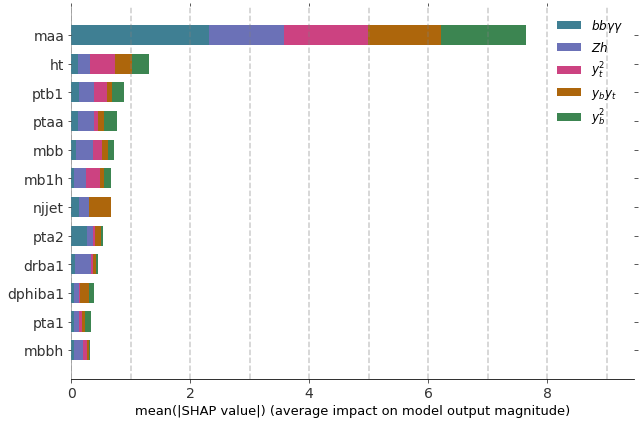

In [43]:
class_names = [r'$bb\gamma\gamma$', r'$Zh$', r'$y_t^2$', r'$y_by_t$', r'$y_b^2$']
filename = 'models/FCC-BDT/hbb-BDT-multiclass-bg-1b-met-ht-btag.pickle.dat'
shap_plot = '../plots/FCC/shap-5.pdf'
classifier, x_test, y_test = runBDT(df_train, class_names=class_names, filename=filename, shap_plot=shap_plot, rf=False, depth=10, sample=1)

#### Load the Classifier and run the analysis. The Accuracy is measured with eqisized samples

In [44]:
classifier = pickle.load(open('models/FCC-BDT/hbb-BDT-multiclass-bg-1b-met-ht-btag.pickle.dat', 'rb'))
comb_test = pd.concat([df_yb2_test.iloc[:,:-1].sample(n=10000, random_state=seed), df_ybyt_test.iloc[:,:-1].sample(n=10000, random_state=seed),
                       df_yt2_test.iloc[:,:-1].sample(n=10000, random_state=seed), df_zh_test.iloc[:,:-1].sample(n=10000, random_state=seed),
                       df_bbxaa_test.iloc[:,:-1].sample(n=10000, random_state=seed)])
print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(comb_test['class'].values, classifier.predict(comb_test.drop(columns=['class']).values))))

Accuracy Score: 55.62% 


#### Check the accuracy of each sample and display the classification plot

Accuracy Score for yb2: 47.95% 
Accuracy Score for ybyt: 26.26% 
Accuracy Score for yt2: 50.95% 
Accuracy Score for zh: 60.87% 
Accuracy Score for bbxaa: 92.94% 


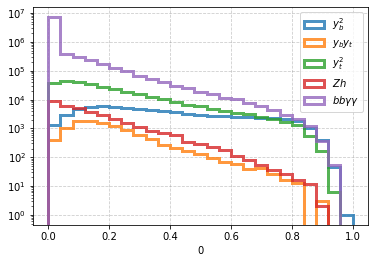

In [45]:
disc = 4
yb2_p = pd.DataFrame(classifier.predict_proba(df_yb2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yb2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yb2_test['class'].values, classifier.predict(df_yb2_test.drop(columns=['class', 'weight']).values))))
yb2_p['weight'] = df_yb2_test['weight'].values

ybyt_p = pd.DataFrame(classifier.predict_proba(df_ybyt_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for ybyt: {:4.2f}% '.format(100*metrics.accuracy_score(df_ybyt_test['class'].values, classifier.predict(df_ybyt_test.drop(columns=['class', 'weight']).values))))
ybyt_p['weight'] = df_ybyt_test['weight'].values

yt2_p = pd.DataFrame(classifier.predict_proba(df_yt2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yt2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yt2_test['class'].values, classifier.predict(df_yt2_test.drop(columns=['class', 'weight']).values))))
yt2_p['weight'] = df_yt2_test['weight'].values

zh_p = pd.DataFrame(classifier.predict_proba(df_zh_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for zh: {:4.2f}% '.format(100*metrics.accuracy_score(df_zh_test['class'].values, classifier.predict(df_zh_test.drop(columns=['class', 'weight']).values))))
zh_p['weight'] = df_zh_test['weight'].values

bbxaa_p = pd.DataFrame(classifier.predict_proba(df_bbxaa_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(df_bbxaa_test['class'].values, classifier.predict(df_bbxaa_test.drop(columns=['class', 'weight']).values))))
bbxaa_p['weight'] = df_bbxaa_test['weight'].values

yb2_pred = yb2_p.sample(n=round(weight_yb2*1.5), replace=True).reset_index(drop=True)
ybyt_pred = ybyt_p.sample(n=round(weight_ybyt*1.9), replace=True).reset_index(drop=True)
yt2_pred = yt2_p.sample(n=round(weight_yt2*2.5), replace=True).reset_index(drop=True)
zh_pred = zh_p.sample(n=round(weight_zh*1.93), replace=True).reset_index(drop=True)
bbxaa_pred = bbxaa_p.sample(n=round(weight_bbxaa*1.5), replace=True).reset_index(drop=True)

plt.figure(figsize=(6,4))
sns.distplot(yb2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_b^2$')
sns.distplot(ybyt_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_by_t$')
sns.distplot(yt2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_t^2$')
sns.distplot(zh_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$Zh$')
sns.distplot(bbxaa_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$bb\gamma\gamma$')
plt.legend()
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.yscale('log')

#### Since ybyt has both positive and negative weights the confusion matrix has to be created separately for each

In [46]:
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.93, weight_yt2*2.5, weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed, replace=True), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed, replace=True), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed, replace=True), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed, replace=True),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 64.01, yb2 events: 35381, ybyt events: 1646, yt2 events: 54708, zh events: 3235, bbxaa events: 210575
sig: 7.77, yb2 events: 5725, ybyt events: 2851, yt2 events: 14935, zh events: 2002, bbxaa events: 108998
sig: 288.10, yb2 events: 12032, ybyt events: 1333, yt2 events: 157461, zh events: 3734, bbxaa events: 124164
sig: 42.45, yb2 events: 8535, ybyt events: 1787, yt2 events: 47295, zh events: 21363, bbxaa events: 174337
sig: 2838.97, yb2 events: 12106, ybyt events: 3202, yt2 events: 34961, zh events: 4745, bbxaa events: 8114372


In [47]:
df_ybyt_test_pos = df_ybyt_test[df_ybyt_test['weight']==1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_pos, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.93, weight_yt2*2.5, (1./(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class_pos = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed, replace=True), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed, replace=True), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed, replace=True), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed, replace=True),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion_pos = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 64.16, yb2 events: 35465, ybyt events: 930, yt2 events: 54836, zh events: 3242, bbxaa events: 211071
sig: 4.90, yb2 events: 5771, ybyt events: 1797, yt2 events: 15054, zh events: 2018, bbxaa events: 109870
sig: 288.58, yb2 events: 12052, ybyt events: 837, yt2 events: 157724, zh events: 3741, bbxaa events: 124372
sig: 42.50, yb2 events: 8545, ybyt events: 1479, yt2 events: 47353, zh events: 21389, bbxaa events: 174550
sig: 2839.30, yb2 events: 12108, ybyt events: 2243, yt2 events: 34965, zh events: 4746, bbxaa events: 8115325


In [48]:
df_ybyt_test_neg = df_ybyt_test[df_ybyt_test['weight']==-1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_neg, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.93, weight_yt2*2.5, (ybyt_ratio/(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class_pos = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed, replace=True), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed, replace=True), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed, replace=True), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed, replace=True),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion_neg = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 63.74, yb2 events: 35233, ybyt events: 2920, yt2 events: 54478, zh events: 3221, bbxaa events: 209693
sig: 13.16, yb2 events: 5639, ybyt events: 4826, yt2 events: 14711, zh events: 1972, bbxaa events: 107362
sig: 287.18, yb2 events: 11994, ybyt events: 2282, yt2 events: 156958, zh events: 3723, bbxaa events: 123768
sig: 42.29, yb2 events: 8504, ybyt events: 2694, yt2 events: 47125, zh events: 21286, bbxaa events: 173708
sig: 2838.25, yb2 events: 12103, ybyt events: 5258, yt2 events: 34952, zh events: 4744, bbxaa events: 8112330


#### The Confusion Matrix, total events count for each channel and the signal significance

In [49]:
confusion_tot = np.round(np.array([confusion_pos[4]*0.5, confusion_pos[3], confusion_pos[2]*0.5, confusion_pos[1]*0.5, confusion_pos[0]*0.5])
        +np.array([confusion_neg[4]*0.5, -confusion_neg[3], confusion_neg[2]*0.5, confusion_neg[1]*0.5, confusion_neg[0]*0.5])).astype(int)
confusion_tot_tmp = confusion_tot
event_total = np.array([[np.sum(confusion_tot[i])] for i in range(confusion_tot.shape[0])])
significance = np.array([np.abs(confusion_tot[i,i])/np.sqrt(np.sum(confusion_tot[:,i])) for i in range(confusion_tot.shape[0])])
significance = np.append(significance, 0)
confusion_tab1 = np.append(confusion_tot_tmp, event_total, axis=1)
confusion_tab2 = np.vstack((confusion_tab1, significance))
    
df_conf = pd.DataFrame(confusion_tab2, [r'$y_b^2$', r'$y_by_t$', r'$y_t^2$', r'$Zh$', r'$bb\gamma\gamma$', r'$\sigma$'])
df_conf.columns = [r'$y_b^2$', r'$y_by_t$', r'$y_t^2$', r'$Zh$', r'$bb\gamma\gamma$', 'total']
print(df_conf.to_latex(escape=False))

\begin{tabular}{lrrrrrr}
\toprule
{} &        $y_b^2$ &       $y_by_t$ &        $y_t^2$ &          $Zh$ &  $bb\gamma\gamma$ &      total \\
\midrule
$y_b^2$          &   35349.000000 &    5705.000000 &   12023.000000 &    8524.00000 &      1.210600e+04 &    73707.0 \\
$y_by_t$         &   -1990.000000 &   -3029.000000 &   -1445.000000 &   -1215.00000 &     -3.015000e+03 &   -10694.0 \\
$y_t^2$          &   54657.000000 &   14882.000000 &  157341.000000 &   47239.00000 &      3.495800e+04 &   309077.0 \\
$Zh$             &    3232.000000 &    1995.000000 &    3732.000000 &   21338.00000 &      4.745000e+03 &    35042.0 \\
$bb\gamma\gamma$ &  210382.000000 &  108616.000000 &  124070.000000 &  174129.00000 &      8.113828e+06 &  8731025.0 \\
$\sigma$         &      64.363532 &       8.460729 &     289.334901 &      42.67472 &      2.839952e+03 &        0.0 \\
\bottomrule
\end{tabular}

